In [1]:
import time
from tqdm import tqdm
from pathlib import WindowsPath

import cv2
import random
import numpy as np
import SimpleITK as sitk
from PIL import Image, ImageFilter

import skimage.io as sio
from skimage.measure import label
from skimage.color import label2rgb
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import watershed, expand_labels, find_boundaries, clear_border
from skimage.morphology import disk, erosion, dilation, closing, \
    binary_dilation, binary_erosion, binary_closing, remove_small_objects, convex_hull_image


from cellpaint.steps_single_plate._segmentation import SegmentationPartI, SegmentationPartII
from cellpaint.steps_single_plate.step0_args import Args, \
    load_img, sort_key_for_imgs, get_img_channel_groups, set_mask_save_name


import torch
from cellpose import models
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
# %matplotlib qt

In [2]:
# path to where the data is
camii_server_flav = r"..."
# which experiment
exp_fold = "..."
main_path = WindowsPath(camii_server_flav)
args = Args(experiment=exp_fold, main_path=main_path, mode="preview").args

self.args.imgs_fold: AssayPlate_PerkinElmer_CellCarrier-384
anchor treatment: dmso   anchor cell-line: rt4   anchor density: 3000   anchor dosage: 0   anchor other: 0
control_treatments:  ['dmso' 'outer' 'berb' 'actd']


In [3]:
def get_wellid(x, args):
    return sort_key_for_imgs(x, "to_get_well_id", args.plate_protocol)

def set_custom_datasets_hyperparameters(args):
    ##############################################################################
    # intensity rescaling hyperparameters
    args.w1_intensity_bounds = (5, 99.95)
    args.w2_intensity_bounds = (5, 99.95)
    args.w3_intensity_bounds = (5, 99.95)
    args.w4_intensity_bounds = (5, 99.95)
    args.w5_intensity_bounds = (5, 99.95)
    ##########################################################################
    # background correction hyperparameters
    """Set args.bg_sub to True first if you decide to do background subtraction."""
    args.bg_sub = False
    args.w1_bg_rad = 50
    args.w2_bg_rad = 100
    args.w3_bg_rad = 50
    args.w4_bg_rad = 100
    args.w5_bg_rad = 100
    #######################################################################
    # image channels order/index during data acquisition set by the investigator/microscope
    args.nucleus_idx = 0
    args.cyto_idx = 1
    args.nucleoli_idx = 2
    args.actin_idx = 3
    args.mito_idx = 4
    #######################################################################
    # hyperparameters/constants used in Cellpaint Step 2
    args.step2_segmentation_algorithm = "w1=cellpose_w2=cellpose"
    args.cellpose_nucleus_diam = 100
    args.cellpose_cyto_diam = 100
    args.cellpose_batch_size = 64
    args.cellpose_model_type = "cyto2"
    args.w1_min_size = 600
    args.w2_min_size = 700
    args.w3_min_size = 40
    args.w5_min_size = 200
    #######################################################
    # hyperparameters/constants used in Cellpaint Step 3
    args.multi_nucleus_dist_thresh = 40
    args.min_nucleoli_size_multiplier = .005
    args.max_nucleoli_size_multiplier = .3
    args.nucleoli_bd_area_to_nucleoli_area_threshold = .2
    args.w3_local_rescale_intensity_ub = 99.2
    args.w5_local_rescale_intensity_ub = 99.9
    return args

In [4]:
# choose your sample wells from the plate
sample_wellids = ["A01"]
args = set_custom_datasets_hyperparameters(args)
# restrict it to a few images
args.img_filepaths = sorted(filter(
    lambda x: np.isin(get_wellid(x, args), sample_wellids), args.img_filepaths))
args.img_filename_keys, args.img_channels_filepaths, args.N = get_img_channel_groups(args)

In [5]:
# choose an idx  (index)
idx = 0
# get the path to the 5 channels as a list 
img_group = args.img_channels_filepaths[idx]
# get keys
filename_key = args.img_filename_keys[idx]
exp_id, well_id, fov = filename_key[0], filename_key[1], filename_key[2]
# load the 5 channel iamge
img = load_img(img_group, args)

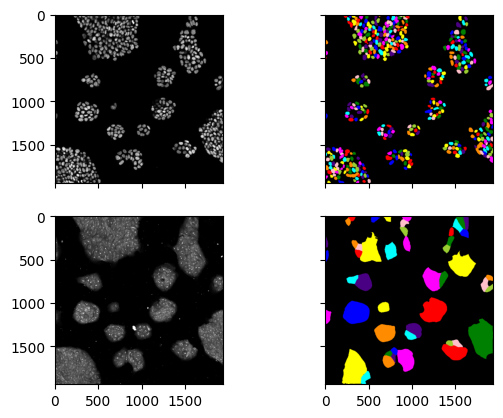

In [6]:
# run segmentation step1 to get nucleus and cytoplasm masks
cellpaint_segmentation_step1 = SegmentationPartI(args)
w1_mask, w2_mask = cellpaint_segmentation_step1.get_cellpose_masks(
    img_group, filename_key)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes[0, 0].imshow(img[0], cmap="gray")
axes[0, 1].imshow(label2rgb(w1_mask, bg_label=0), cmap="gray")
axes[1, 0].imshow(img[1], cmap="gray")
axes[1, 1].imshow(label2rgb(w2_mask, bg_label=0), cmap="gray")
# axes[2, 0].axis("off")
plt.show()

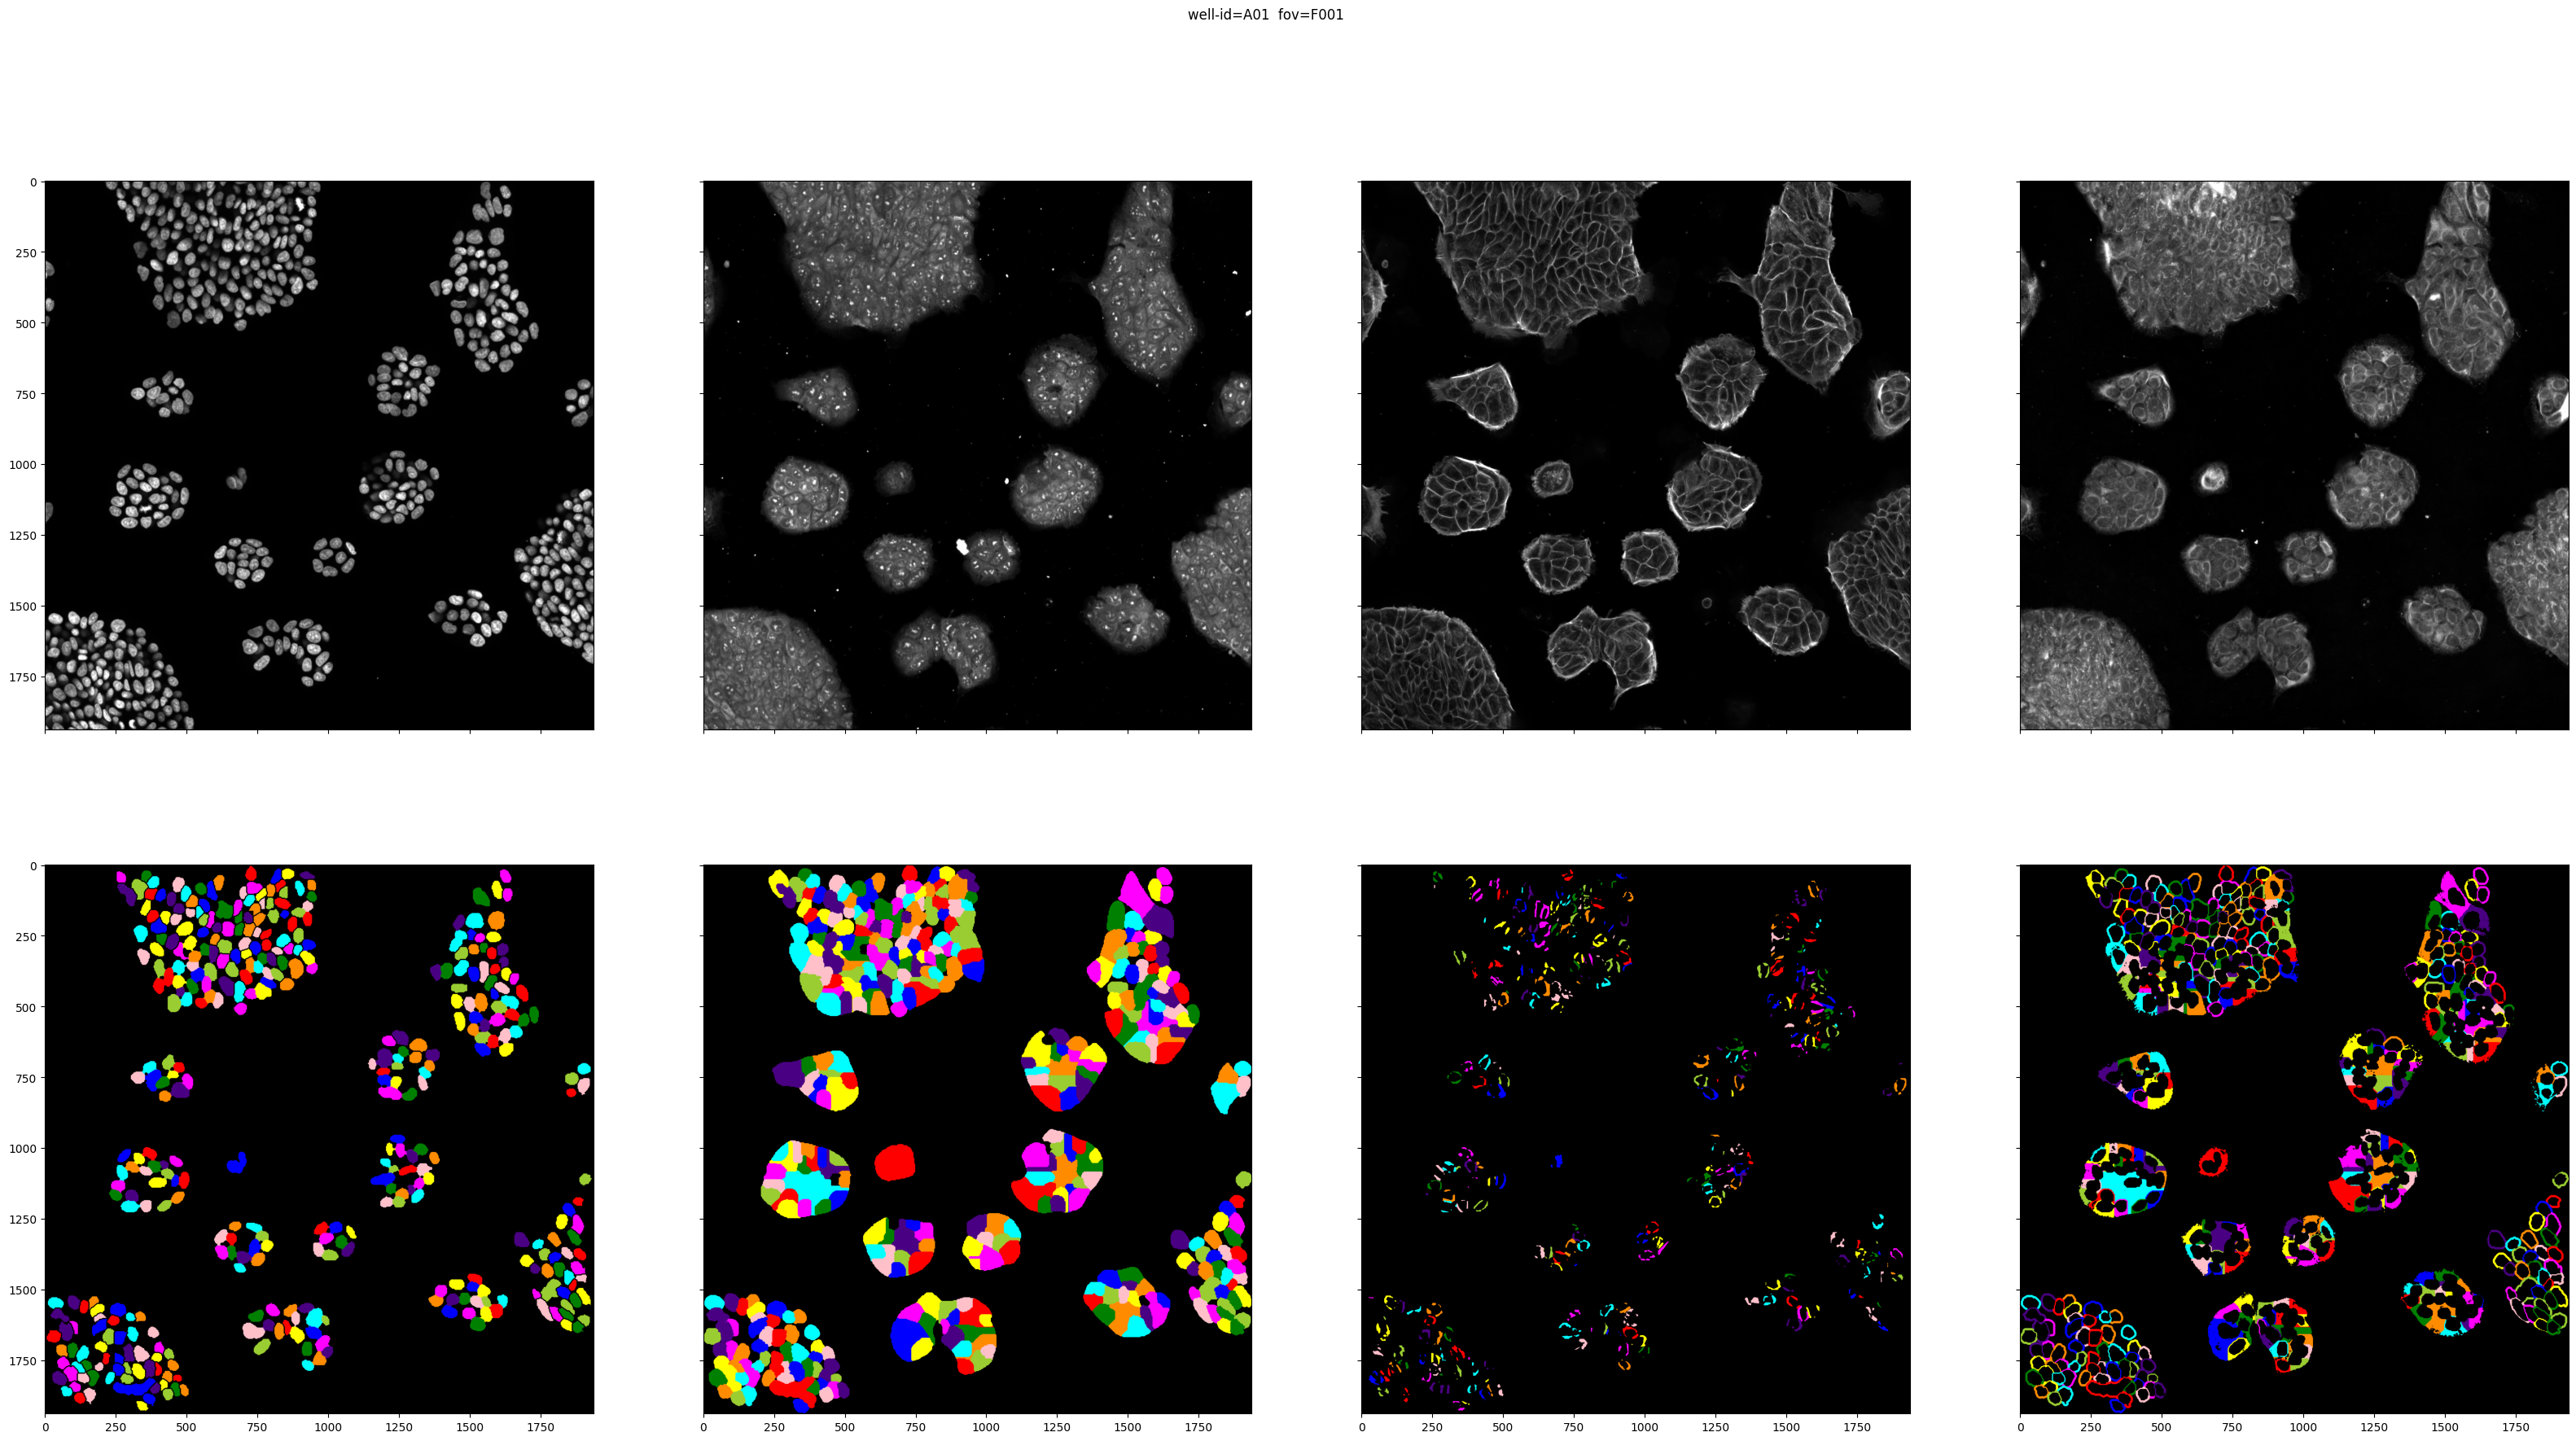

In [7]:
# run segmentation step2 to match cytoplasm and nucleus and masks, as well as,
# nucleoli and mitocondria masks
cellpaint_segmentation_step2 = SegmentationPartII(args)
w1_mask, w2_mask, w3_mask, w5_mask = cellpaint_segmentation_step2.run_demo(
    img_group, img, w1_mask, w2_mask)

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(40, 20)
fig.suptitle(f"well-id={well_id}  fov={fov}")
axes[0, 0].imshow(img[0], cmap="gray")
axes[0, 1].imshow(img[1], cmap="gray")
axes[0, 2].imshow(img[2], cmap="gray")
axes[0, 3].imshow(img[4], cmap="gray")
axes[1, 0].imshow(label2rgb(w1_mask), cmap="gray")
axes[1, 1].imshow(label2rgb(w2_mask), cmap="gray")
axes[1, 2].imshow(label2rgb(w3_mask), cmap="gray")
axes[1, 3].imshow(label2rgb(w5_mask), cmap="gray")
plt.show()